In [1]:
%matplotlib inline

import json

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from pathlib import Path

from tqdm import tqdm, tqdm_notebook

HBox(children=(IntProgress(value=1, bar_style='info', max=1), HTML(value='')))

In [112]:
tqdm_notebook().pandas()

pd.set_option('precision',2)

sns.set_style("darkgrid")

HBox(children=(IntProgress(value=1, bar_style='info', max=1), HTML(value='')))

In [2]:
data_folder = Path("data/pkp/")
input_file = data_folder / "PKP_20171220.csv"

In [213]:
def extract_fb_shares(df):
    result_cols = [
        'pkp', 'pkp_ogid',
        'pmid', 'pmid_ogid',
        'pmc', 'pmc_ogid',
        'doi', 'doi_ogid',
        'total'
    ]
    shares = pd.DataFrame(columns=result_cols, index=set(df.index))
    
    rows = list(df[df.og_obj.notnull()].itertuples())
    for row in tqdm_notebook(rows, total=len(rows)):
        shares.loc[row.Index, row.type.split("_")[0] + "_ogid"] = str(json.loads(row.og_obj)['id'])
        shares.loc[row.Index, row.type.split("_")[0]] = float(json.loads(row.og_eng)['share_count'])
        
    return shares

def extract_am_shares(df):
    result_cols = ['am', 'am_id']
    shares = pd.DataFrame(columns=result_cols, index=set(df.index))
    
    rows = list(df[df.am_resp.notnull()].itertuples())
    for row in tqdm_notebook(rows, total=len(rows)):
        if pd.notnull(row.am_resp):
            try:
                shares.loc[row.Index, "am_id"] = str(json.loads(row.am_resp)['altmetric_id'])
            except:
                shares.loc[row.Index, "am_id"] = None
            try:
                shares.loc[row.Index, "am"] =  float(json.loads(row.am_resp)['counts']['facebook']['posts_count'])
            except:
                shares.loc[row.Index, "am"] = 0.0
        #if pd.notnull(row.og_eng):
        #    shares.loc[row.doi, row.type.split("_")[0]] =  int(json.loads(row.og_eng)['share_count'])
        
    return shares

In [214]:
df_input = pd.read_csv(input_file,
                       index_col="doi",
                       parse_dates=["date"]).drop_duplicates()
df_input['year'] = df_input.date.apply(lambda x: x.year)

am_results = pd.read_csv(data_folder / "am_responses_filtered.csv",
                         index_col="doi",
                         parse_dates=['am_ts'])
fb_results = pd.read_csv(data_folder / "fb_responses_filtered.csv",
                         index_col="doi",
                         parse_dates=['ts'],
                         dtype={'doi': str, 'type': str, 'url': str, 'og_obj': str, 'og_eng': str, 'og_err': str})
am_results = am_results.replace("null", np.nan)

In [215]:
fb_shares = extract_fb_shares(fb_results)
am_shares = extract_am_shares(am_results)

HBox(children=(IntProgress(value=0, max=63027), HTML(value='')))

HBox(children=(IntProgress(value=0, max=15953), HTML(value='')))

In [216]:
fb_shares[['pkp', 'pmid', 'doi', 'pmc']] = fb_shares[['pkp', 'pmid', 'doi', 'pmc']].astype(float)
am_shares['am'] = am_shares['am'].astype(float)

In [218]:
# Some URLs have been assigned to the same Facebook OG IDs
# Those share numbers should be investigated in more detail
# but for now they are simply being overwritten with NaNs

ids = ['pkp_ogid', 'pmc_ogid', 'pmid_ogid', 'doi_ogid']

for _ in ids:
    bad_ones = fb_shares[(~fb_shares[_].isnull() & fb_shares.duplicated(subset=[_], keep=False))].index
    fb_shares.loc[bad_ones, _.split("_")[0]] = np.nan
    print("Duplicate {} IDs: {}".format(_, len(bad_ones)))

Duplicate pkp_ogid IDs: 303
Duplicate pmc_ogid IDs: 0
Duplicate pmid_ogid IDs: 0
Duplicate doi_ogid IDs: 41


In [219]:
# Sum of the individual FB shares (doi, pkp, pmc, pmid) but taking
# into account that some URLs are identical for resolved DOI and
# original PKP ones.
# 
# DOI == PKP: sum(pkp, pmc, pmid)
# DOI != PKP: sum(pkp, doi, pmc, pmid)

x = fb_results[fb_results.type.isin(['pkp_url', 'doi_url'])][['url']].copy()
x['netloc'] = x.url.apply(lambda x: urllib.parse.urlparse(x).netloc)
x['path'] = x.url.apply(lambda x: urllib.parse.urlparse(x).path)
doi_pkp_identical = x[x[['netloc', 'path']].duplicated()].index

fb_shares['fb'] = fb_shares[['pkp', 'pmc', 'pmid', 'doi']].sum(axis=1)
fb_shares.loc[doi_pkp_identical, 'fb'] = fb_shares.loc[doi_pkp_identical, ['pkp', 'pmc', 'pmid']].sum(axis=1)

In [243]:
# Merge FB shares, AM shares, publication years, and the diff between FB & AM

shares = fb_shares.merge(am_shares, left_index=True, right_index=True)
shares = shares.merge(df_input[['year']], left_index=True, right_index=True)
shares['diff'] = shares['fb'] - shares['am']

In [248]:
# Also restrict to a certain timespan

min_year = 2000
max_year = 2017
smaller = shares[shares['year'].between(min_year, max_year)]
print("Total number of removed rows: {}".format(len(shares) - len(smaller)))
shares = smaller

Total number of removed rows: 28


In [249]:
shares.describe()

,pkp,pmid,pmc,doi,fb,am,year,diff
count,31982.00,391.00,3742.00,22655.00,53251.00,15990.00,244630.00,10214.00
mean,0.72,2.75,0.74,0.72,0.81,0.76,2012.51,1.35
std,11.05,25.04,8.52,3.75,11.14,3.08,4.05,21.75
min,0.00,0.00,0.00,0.00,0.00,0.00,2000.00,-70.00
25%,0.00,0.00,0.00,0.00,0.00,0.00,2011.00,0.00
50%,0.00,0.00,0.00,0.00,0.00,0.00,2013.00,0.00
75%,0.00,1.00,0.00,1.00,1.00,1.00,2016.00,1.00
max,1847.00,396.00,303.00,310.00,2081.00,276.00,2017.00,1805.00


In [269]:
shares.fillna(0).describe()

,pkp,pmid,pmc,doi,total,fb,am,year,diff
count,244630.00,2.45e+05,244630.00,244630.00,244630.0,244630.00,244630.00,244630.00,244630.00
mean,0.09,4.39e-03,0.01,0.07,0.0,0.18,0.05,2012.51,0.06
std,4.00,1.01e+00,1.06,1.16,0.0,5.21,0.81,4.05,4.45
min,0.00,0.00e+00,0.00,0.00,0.0,0.00,0.00,2000.00,-70.00
25%,0.00,0.00e+00,0.00,0.00,0.0,0.00,0.00,2011.00,0.00
50%,0.00,0.00e+00,0.00,0.00,0.0,0.00,0.00,2013.00,0.00
75%,0.00,0.00e+00,0.00,0.00,0.0,0.00,0.00,2016.00,0.00
max,1847.00,3.96e+02,303.00,310.00,0.0,2081.00,276.00,2017.00,1805.00


In [251]:
shares[(shares.pkp.notnull()) & (shares.pmid.notnull()) & (shares.pmc.notnull()) & (shares.doi.notnull())].describe()

,pkp,pmid,pmc,doi,fb,am,year,diff
count,25.00,25.0,25.00,25.00,25.00,24.00,25.00,24.00
mean,95.88,19.4,20.44,2.76,138.48,27.62,2014.24,116.50
std,372.25,79.6,64.61,7.79,458.93,61.80,1.64,410.79
min,0.00,0.0,0.00,0.00,1.00,0.00,2011.00,-70.00
25%,1.00,0.0,0.00,0.00,3.00,1.00,2013.00,0.75
50%,2.00,0.0,2.00,0.00,7.00,2.00,2014.00,2.00
75%,9.00,0.0,4.00,1.00,20.00,10.00,2016.00,11.00
max,1847.00,396.0,303.00,33.00,2081.00,276.00,2016.00,1805.00


In [252]:
shares[shares.am.notnull()].describe()

,pkp,pmid,pmc,doi,fb,am,year,diff
count,7007.00,309.00,2873.00,3236.00,10214.00,15990.00,15990.00,10214.00
mean,2.15,3.37,0.93,1.65,2.35,0.76,2013.62,1.35
std,23.24,28.15,9.71,4.90,24.71,3.08,3.04,21.75
min,0.00,0.00,0.00,0.00,0.00,0.00,2000.00,-70.00
25%,0.00,0.00,0.00,0.00,0.00,0.00,2012.00,0.00
50%,1.00,0.00,0.00,1.00,1.00,0.00,2014.00,0.00
75%,2.00,1.00,0.00,2.00,2.00,1.00,2016.00,1.00
max,1847.00,396.00,303.00,136.00,2081.00,276.00,2017.00,1805.00


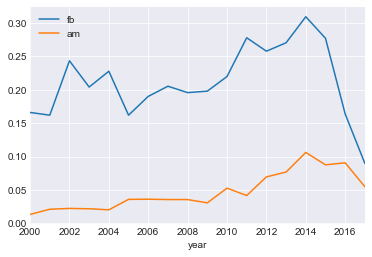

In [261]:
shares.groupby('year')[['fb','am']].apply(lambda x: x.notnull().mean()).plot()

------

Quite interesting case of an article that has a lot of private shares based on PMC and PubMed, little shares for the PKP and none for the DOI (which is invalid)

https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4791148/

# Old Code

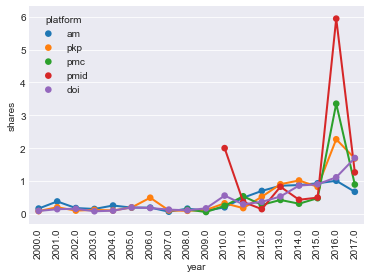

In [258]:
_ = shares[['year', 'am', 'pkp', 'pmc', 'pmid', 'doi']].melt(id_vars = ['year'], var_name="platform", value_name="shares")
sns.pointplot(x="year", y="shares", hue="platform",
              data=_,
             scale=.75, ci=False);
plt.xticks(rotation=90);

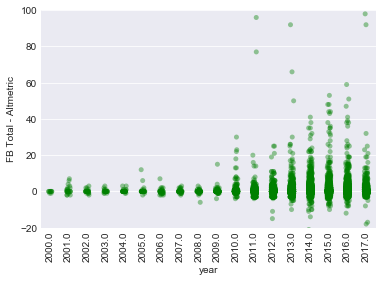

In [259]:
sns.stripplot(x="year", y="diff", data=shares, jitter=True, dodge=True, alpha=.4, color="g");
plt.xticks(rotation=90);
plt.ylim(-20,100)
plt.ylabel('FB Total - Altmetric');

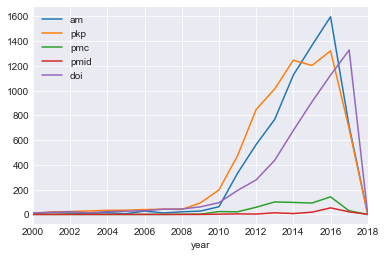

In [116]:
shares.replace(to_replace=0.0, value=np.nan).groupby(['year'])[['am', 'pkp', 'pmc', 'pmid', 'doi']].count().plot();

In [104]:
pdf = shares[['year', 'am', 'total']].melt(id_vars = ['year'], var_name="platform", value_name="shares")

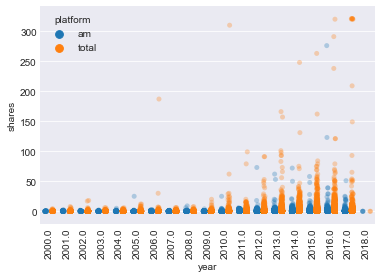

In [121]:
sns.stripplot(x="year", y="shares", hue="platform",
              data=pdf[pdf.shares<500],
             jitter=True, dodge=True, alpha=.3);
plt.xticks(rotation=90);